# 1. 凯利公式是什么？

在我们进行投资或任意性质的赌博时，假设我们可以预估出胜率、赢时的利润率、输时的亏损率，那我们应该拿出多少本金进行投资呢？这就是凯利公式要回答的问题，用数学公式表示则为：$f(p, W, L) = \frac{p \cdot W - (1 - p) \cdot L}{W \cdot L}$.\
其中：
* p ：获胜的概率，取值范围为[0,1]
* W：获胜时的利润率。取值范围为[0,+∞]。① 假设我们投注1块钱，赢得话1块变2块，此时我们的利润率是100%，而不是200%。② 若在股市中，假设我们投资100块，预计涨幅30%（或者说在涨30%时止盈），赢后100变130，那么利润率就是30%，即0.3。
* L：失败时的亏损率。取值范围为[0,1]。① 假设我们投注1块，输的话变为0。则亏损率就是100%。② 股市中，假设我们投资100块，预计下跌10%（或下跌10%时止损），之后100变90，那亏损率就是10%
* f(p, W, L)：该函数的值则为投注的比例。范围是[0,+∞]。这里之所以不是[0,1]，是因为当W很大，而L很小时，凯利公式会让你上杠杆。

# 2. 凯利公式的Python实现

In [ ]:
def kelly_buy_ratio_strategy(
  p: float,  # 获胜概率
  W: float,  # 获胜时的盈利，或止盈点。例如：当上涨时预计盈利为20%，则W=0.2
  L: float,  # 失败时的亏损，或止损点。例如：当下跌10%时止损，则L=0.1
):
  """
  根据“凯利公式”决定买入的仓位比例
  """

  buy_ratio = (p * W - (1 - p) * L) / (W * L)

  if buy_ratio < 0:
    buy_ratio = 0

  return buy_ratio


# 3. 凯利公式数学推导

假设有一种赌博游戏，胜率固定为 $p$，盈利率固定为 $W$，亏损率固定为 $L$。（注意这里 $p$ , $W$ , $L$ 都是常量）。\
假设我们进行 $N$ 次游戏，那么概率上将会有 $N⋅p$ 次获胜，$N⋅(1−p)$ 次失败。\
我们用 $A_{n+1}$ 来表示第 $n$ 次的本金，假设我们每次投注的比例为 $x$，则第 $A_{n+1}$ 次的金额则为：

$A_{n+1} = \begin{cases}
A_n(1 + xW) & \text{if win} \\
A_n(1 - xL) & \text{if lose}
\end{cases}$

我们的初始本金为 $A_0$，进行 $N$ 次游戏，我们的本金变化可能如下：

$\begin{align*}
A_1 &= A_0(1 + xW) & \text{win} \\
A_2 &= A_1(1 - xL) & \text{lose} \\
A_3 &= A_2(1 + xW) & \text{win} \\
& \vdots \\
A_{n-1} &= A_{n-2}(1 - xL) & \text{lose} \\
A_n &= A_{n-1}(1 + xW) & \text{win}
\end{align*}$

上述式子中，每次win和lose都是随机的，但一共有 $N ⋅ p$ 次胜 和 $N ⋅ ( 1 - p )$ 次败。

我们现在消除 $A_1 , A_2 , … , A_{n − 1}$，则式子变为：

$A_n(x) = A_0 (1 + xW)^{Np} (1 - xL)^{N(1-p)}$



我们的目的就是求一个 $x$ ，使得 $A_n$ 最大。可以使用最大似然估计，两边再取对数，式子变为：

$\ln A(x) = Np \ln(1 + xW) + N(1 - p) \ln(1 - xL) + A_0$

为了求得 $x^{*}$，让导数等于0即可。即：

$\frac{d\ln A(x)}{dx} = N\frac{pW}{1 + xW} + N\frac{(1 - p)(-L)}{1 - xL} = 0
$

将 $x^*$ 解出来，当胜率为 $p$，胜利时收益率为 $W$，失败时亏损率为 $L$ 时，最佳的投注比例：

$x^* = \frac{p \cdot W - (1 - p) \cdot L}{W \cdot L}$

# 4. 蒙特卡罗方法验证凯利公式

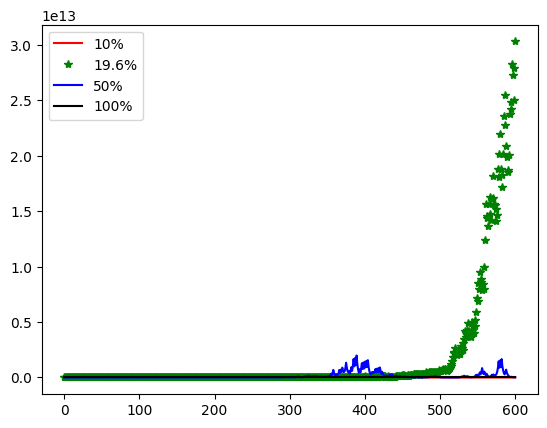

In [95]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

random.seed(42)
p = 0.45  # 胜率
W = 1.5  # 利润率
L = 0.8  # 亏损率

# 凯利值
def kelly(p, W, L):
  f = (p * W - (1 - p) * L) / (W * L)
  if f < 0:
    f = 0
  return f

def play_game(f, cash=100, m=100):
  global p, W, L

  res = [cash]
  for i in range(m):
    if random.random() <= p:
      res.append(res[-1] + int(f*res[-1])*W)
    else:
      res.append(res[-1] - int(f*res[-1])*L)
  return res

# 蒙特卡罗方法重复玩游戏
def montecarlo(n=1000, f=0.15, cash=1000, m=100):
  res = []
  for i in range(n):
      res.append(play_game(f, cash, m))
  return pd.DataFrame(res).sum(axis=0) / n   # 【数学期望】不平滑
  # return np.exp(np.log(pd.DataFrame(res)).sum(axis=0) / n) # 【几何期望】平滑

n = 1000   # 重复次数
cash = 1000  # 初始资金池
m = 600  # 期数

f = kelly(p, W, L)
res1 = montecarlo(n, 0.1, cash, m) # 资金比例 10%
res2 = montecarlo(n, f, cash, m) # 资金比例 凯利值
res3 = montecarlo(n, 0.5, cash, m) # 资金比例 50%
res4 = montecarlo(n, 1, cash, m) # 资金比例 100%

fig = plt.figure()
axes = fig.add_subplot(111)

axes.plot(res1,'r-',label='10%')
axes.plot(res2,'g*',label='{:.1%}'.format(f))
axes.plot(res3,'b-',label='50%')
axes.plot(res4,'k-',label='100%')
plt.legend(loc = 0)

plt.show()

# 5. 改良凯利公式

凯利公式假设每次赌注是独立的，收益率是固定的，投资者对于资金的规模有完美的控制，并且可以连续不断地进行投注。然而，实际情况往往不是这样，可能需要对凯利公式进行一些调整来适应具体情况，例如：

1. 分数凯利：为了减少短期内的资本波动，可以使用凯利建议投注比例的一部分，如一半或四分之一。这会减少资金的增长速度，但降低了风险和波动性。

2. 加入平均赔率变化：如果赔率是变化的，可以在计算过程中加入这一因素。

3. 调整风险偏好：根据个人的风险偏好调整公式，减少或增加投注比例。

4. 资金管理：可以结合其他资金管理策略来调整投注金额，例如固定金额投注或固定比例投注。

5. 历史数据分析：通过分析历史数据来预测 $p$、 $W$ 和 $L$，尽可能提高它们的准确性。

6. 投资组合应用：将凯利公式应用于整个投资组合，而不是单个投注。

7. 动态调整：随着资金的增减和投注机会的变化动态调整投注比例。